In [125]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline

# **1.Data Cleaning and Preprocessing**

**1.1 Data Cleaning**

In [89]:
# Loading the dataset
df = pd.read_csv('Algerian_forest_fires_cleaned.csv')

In [90]:
# Data inspection
print(df.head(25)) #To check how the data i structure
print(df.info())  # To check data types and missing values by feature

    day  month  year  Temperature  RH  Ws  Rain  FFMC   DMC    DC  ISI   BUI  \
0     1      6  2012           29  57  18   0.0  65.7   3.4   7.6  1.3   3.4   
1     2      6  2012           29  61  13   1.3  64.4   4.1   7.6  1.0   3.9   
2     3      6  2012           26  82  22  13.1  47.1   2.5   7.1  0.3   2.7   
3     4      6  2012           25  89  13   2.5  28.6   1.3   6.9  0.0   1.7   
4     5      6  2012           27  77  16   0.0  64.8   3.0  14.2  1.2   3.9   
5     6      6  2012           31  67  14   0.0  82.6   5.8  22.2  3.1   7.0   
6     7      6  2012           33  54  13   0.0  88.2   9.9  30.5  6.4  10.9   
7     8      6  2012           30  73  15   0.0  86.6  12.1  38.3  5.6  13.5   
8     9      6  2012           25  88  13   0.2  52.9   7.9  38.8  0.4  10.5   
9    10      6  2012           28  79  12   0.0  73.2   9.5  46.3  1.3  12.6   
10   11      6  2012           31  65  14   0.0  84.5  12.5  54.3  4.0  15.8   
11   12      6  2012           26  81  1

In [91]:
# Double Checking for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 day            0
month          0
year           0
Temperature    0
RH             0
Ws             0
Rain           0
FFMC           0
DMC            0
DC             0
ISI            0
BUI            0
FWI            0
Classes        0
Region         0
dtype: int64


In [92]:
# Checking for duplicate values

duplicates = df.duplicated()
print("Duplicate Rows:", duplicates.sum())


Duplicate Rows: 0


In [93]:
# Checking if any column has NaN values
df.isna().any()


day            False
month          False
year           False
Temperature    False
RH             False
Ws             False
Rain           False
FFMC           False
DMC            False
DC             False
ISI            False
BUI            False
FWI            False
Classes        False
Region         False
dtype: bool

**1.2 Data Preprocessing**

To determine which features will be used, it is essential to first clarify the meaning of the acronyms in the dataset columns. The features are defined as follows:

FFMC (Fine Fuel Moisture Code): Represents the moisture content of fine fuels, which affects fire ignition.
DMC (Duff Moisture Code): Measures moisture levels in the topsoil, influencing the sustainability of a fire.
DC (Drought Code): Reflects long-term drying conditions and is crucial for understanding larger, more intense fires.
ISI (Initial Spread Index): Indicates the expected rate at which a fire will spread.
BUI (Buildup Index): Combines DMC and DC to reflect the total amount of combustible material.
FWI (Fire Weather Index): The primary target variable that integrates various weather conditions to predict fire intensity.


In [94]:
# The Region feature will be eliminated, as it doesn't provide any insight.
df_new = df.drop(columns=['Region'])

In [95]:
print(df_new['Classes'].unique())  # Check for unique values in Classes feature

['not fire   ' 'fire   ' 'fire' 'fire ' 'not fire' 'not fire '
 'not fire     ' 'not fire    ']


In [96]:
# Cleaning up extra spaces
df_new['Classes'] = df_new['Classes'].str.strip()

print(df_new['Classes'].unique()) 

['not fire' 'fire']


In [97]:
# Data Encoding for the Classes feature
df_new['Classes'] = df_new['Classes'].map({'not fire': 0, 'fire': 1}, na_action='ignore')

In [98]:
df_new.head(6)

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
0,1,6,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,0
1,2,6,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,0
2,3,6,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,0
3,4,6,2012,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,0
4,5,6,2012,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,0
5,6,6,2012,31,67,14,0.0,82.6,5.8,22.2,3.1,7.0,2.5,1


In [99]:
# Standardization
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_new)

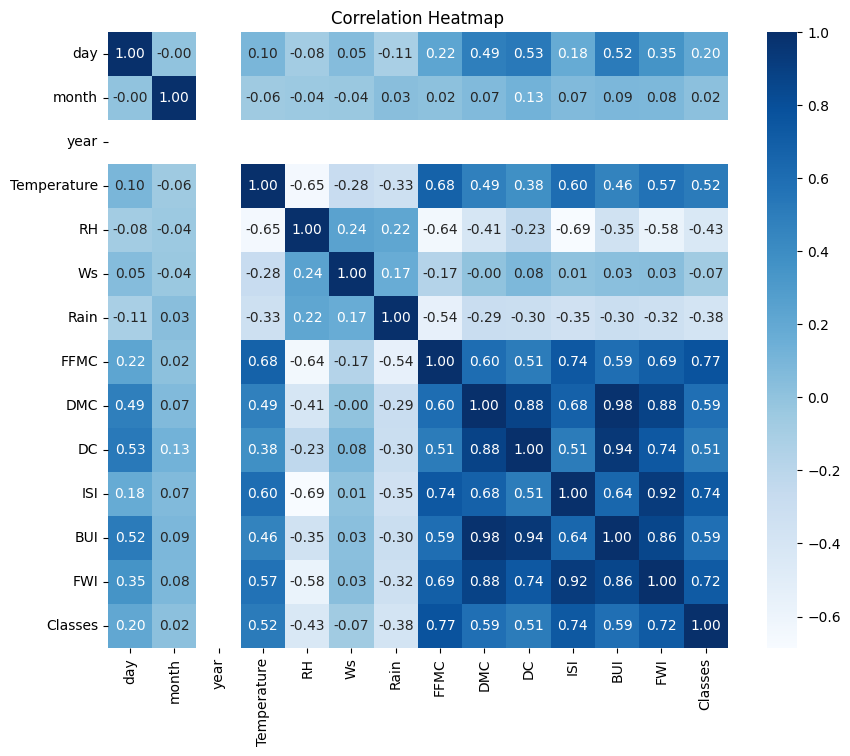

In [101]:
# Creating a correlation matrix to see the correlation of the features with the target variable "FWI"
corr_matrix = df_new.corr()

# Plot the heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

The correlation matrix reveals that the features FFMC, Classes, DC, BUI, and ISI exhibit a strong positive correlation with the Fire Weather Index (FWI), ranging from 0.69 to 0.92. This indicates that these variables have a significant impact on determining the FWI. In contrast, the features representing day, month, year, Wind Speed (Ws), and Rain show very weak or negligible correlations with FWI. Additionally, temperature has a moderate correlation of 0.52, while Relative Humidity (RH) demonstrates a negative correlation of -0.58. Based on these findings, it may be beneficial to eliminate the day, month, year, Wind Speed, and Rain features from the dataset, as they do not contribute meaningfully to predicting the FWI.

In summary, dryness levels are the primary drivers of fire risk, with moisture serving as a factor that reduces this risk. Interestingly, temperature does not exert as significant an influence on fires as one might expect. Therefore, it is crucial to monitor these important variables, especially the dryness indices, to ensure effective fire risk prediction and management.

In [103]:
# Eliminating the corresponding columns

df_final = df_new.drop(columns=['day','month','year','Ws','Rain'])

In [104]:
df_final.head(5)

,Temperature,RH,FFMC,DMC,DC,ISI,BUI,FWI,Classes
0,29,57,65.7,3.4,7.6,1.3,3.4,0.5,0
1,29,61,64.4,4.1,7.6,1.0,3.9,0.4,0
2,26,82,47.1,2.5,7.1,0.3,2.7,0.1,0
3,25,89,28.6,1.3,6.9,0.0,1.7,0.0,0
4,27,77,64.8,3.0,14.2,1.2,3.9,0.5,0


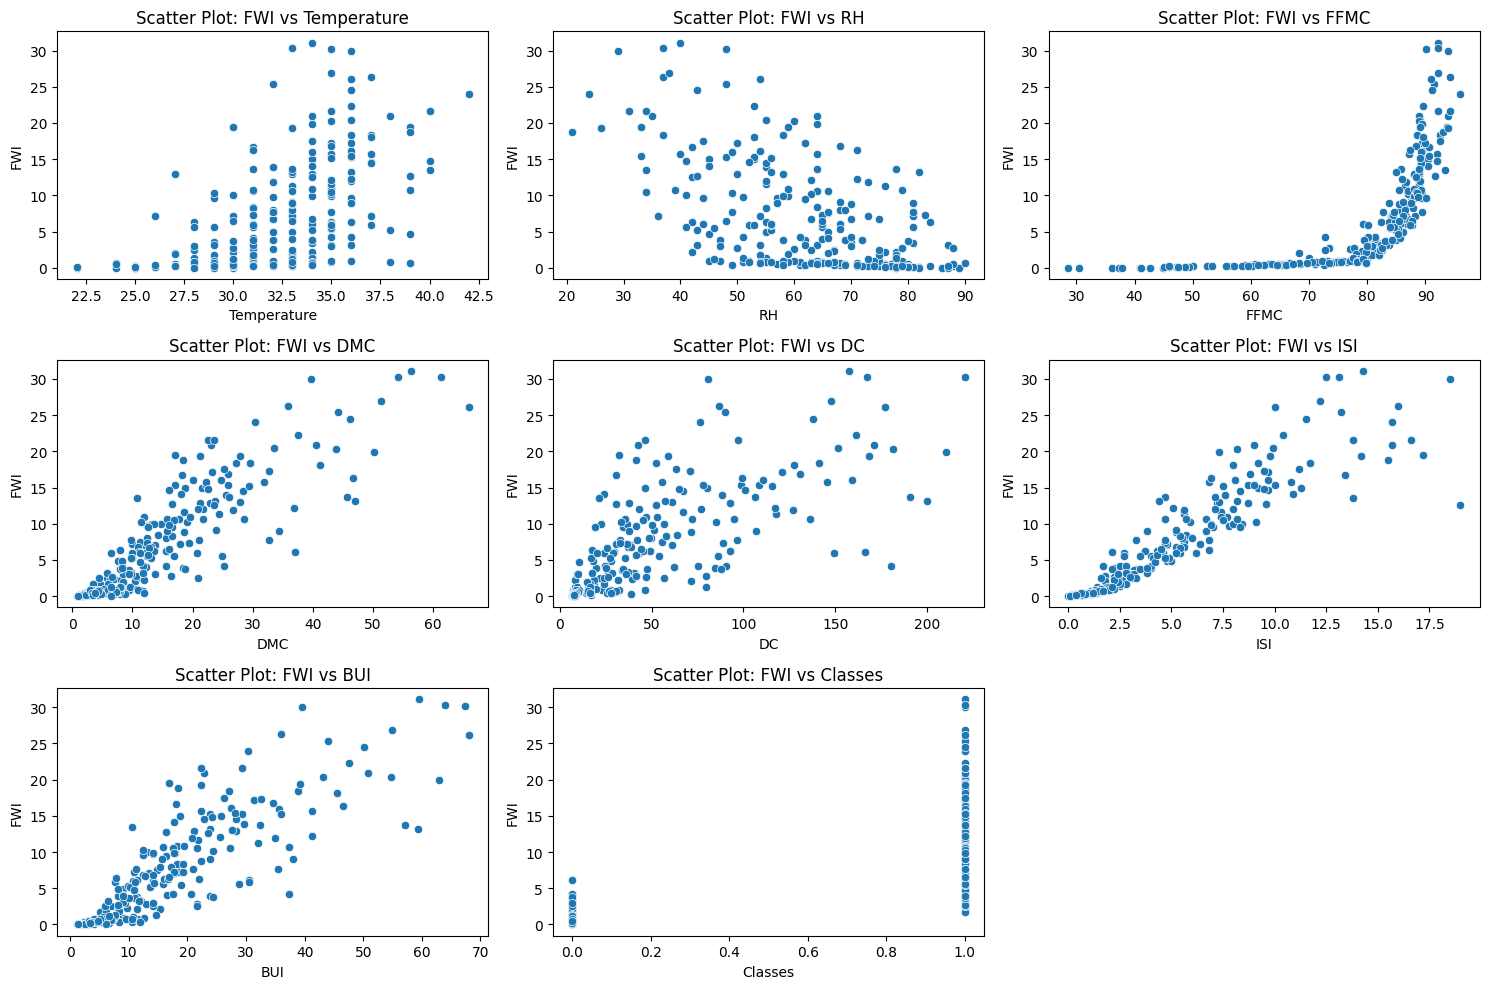

In [109]:
# List of features to plot against FWI
features = df_final.columns.tolist()  # Get all columns from df_final
features.remove('FWI')  # Remove FWI from the list to avoid plotting it against itself

# Create a scatter plot for each feature against FWI
plt.figure(figsize=(15, 10))

for i, feature in enumerate(features):
    plt.subplot(3, 3, i + 1)  # Create a grid of subplots
    sns.scatterplot(data=df_final, x=feature, y='FWI')
    plt.title(f'Scatter Plot: FWI vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('FWI')

plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()


#**2.Data Visualization and Observations**


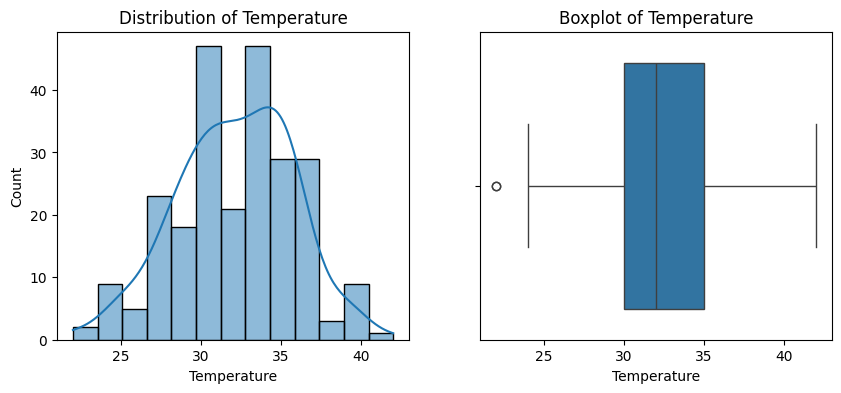

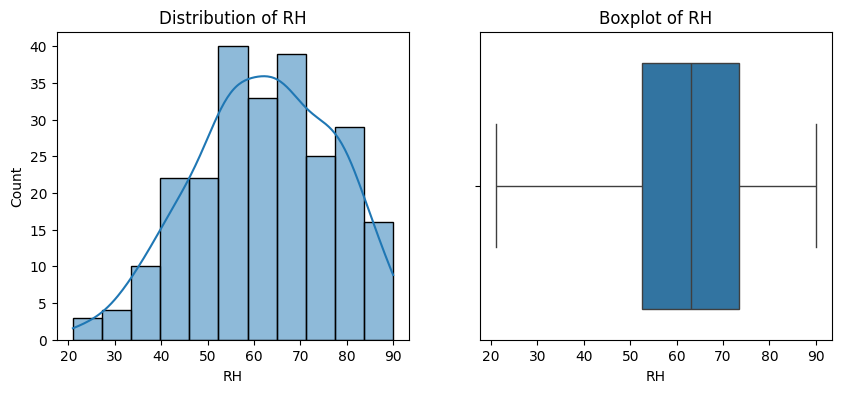

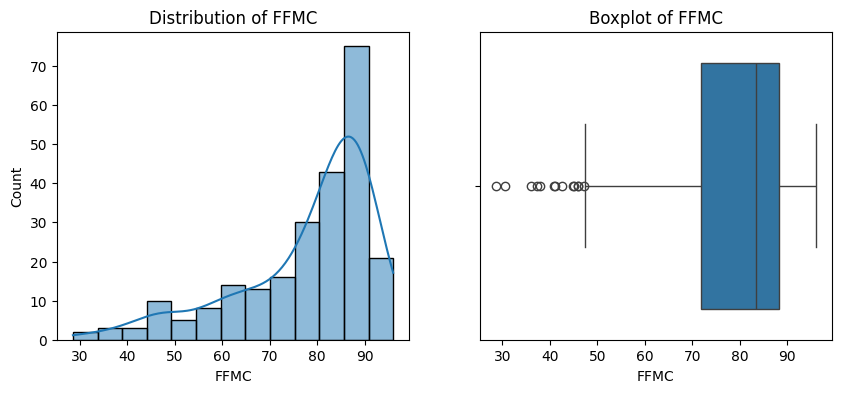

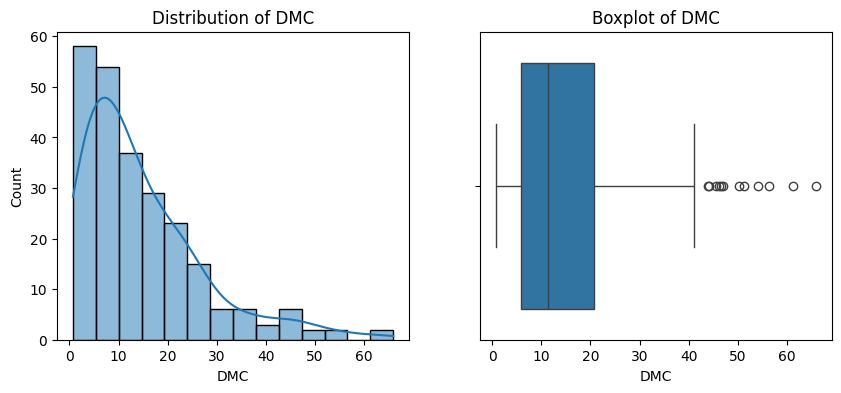

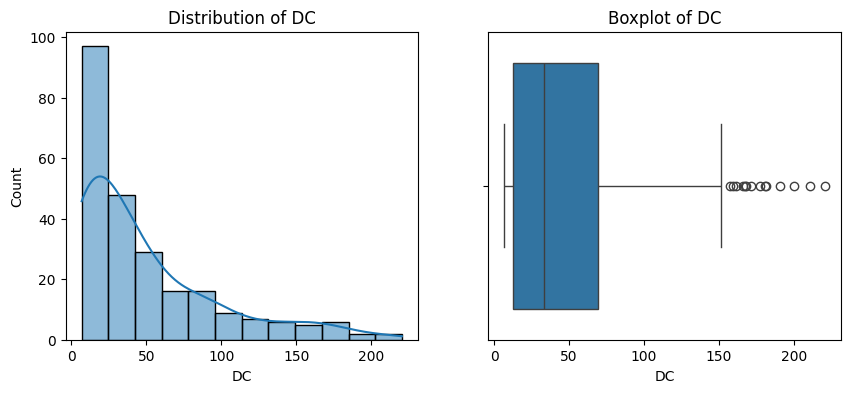

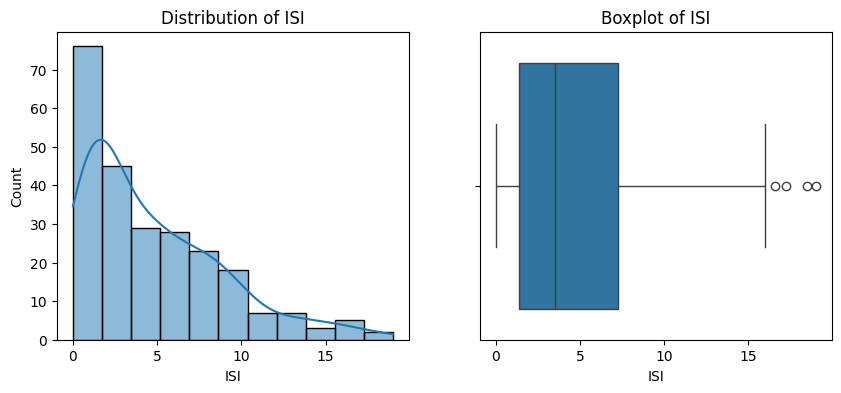

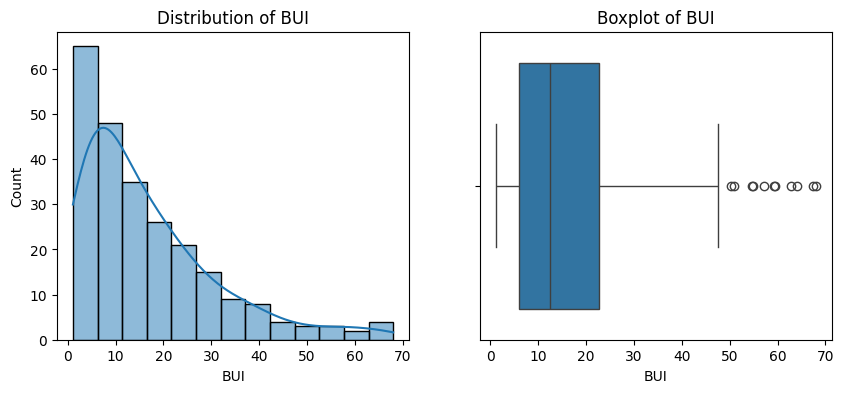

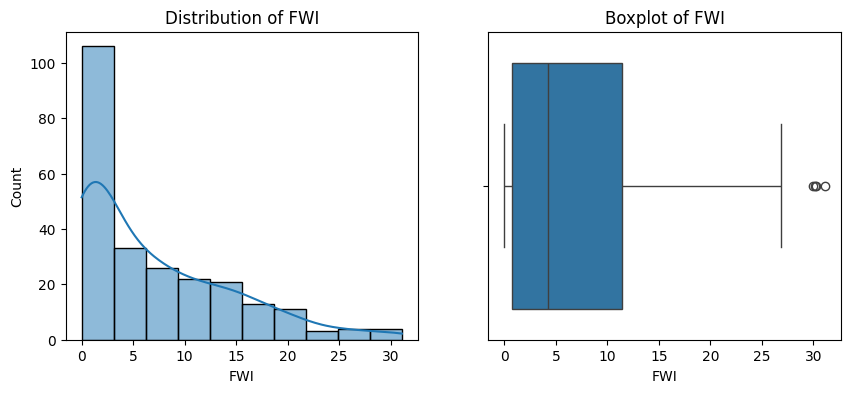

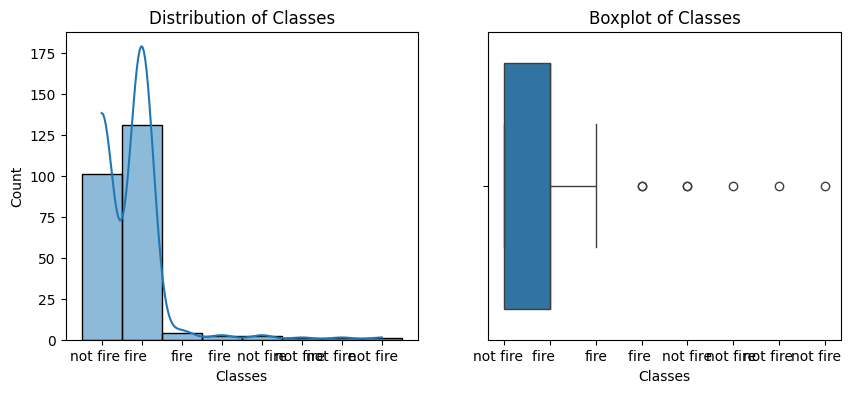

In [105]:
 #Creating distibution plots and box plots for each of the final features
for column in df_final.columns:
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

The analysis reveals that the Temperature and Relative Humidity (RH) features exhibit a distribution resembling a normal curve, while the Fine Fuel Moisture Code (FFMC) is skewed toward the right. In contrast, the remaining features show a leftward skew. Notably, Temperature contains one outlier, whereas RH appears to be free of outliers. However, several outliers can be easily identified in the other features.

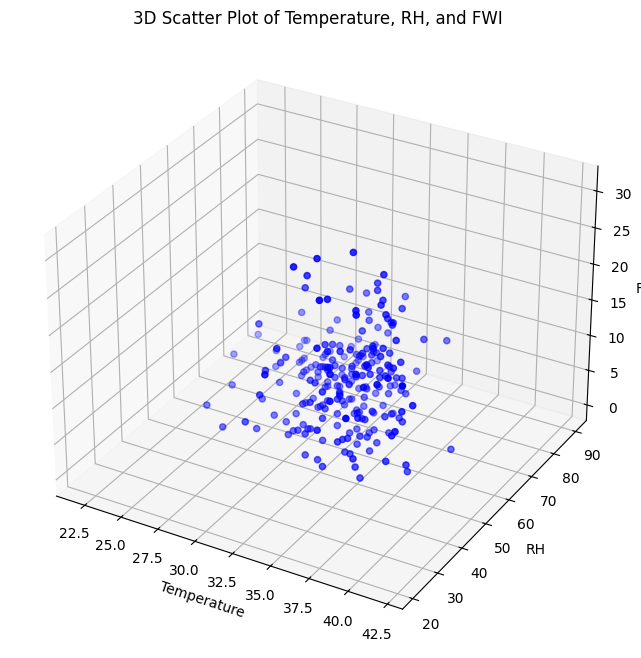

In [113]:
# Select three key features for 3D visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_final['Temperature'], df_final['RH'], df_final['FWI'], c='blue', marker='o')

ax.set_xlabel('Temperature')
ax.set_ylabel('RH')
ax.set_zlabel('FWI')
plt.title('3D Scatter Plot of Temperature, RH, and FWI')
plt.show()

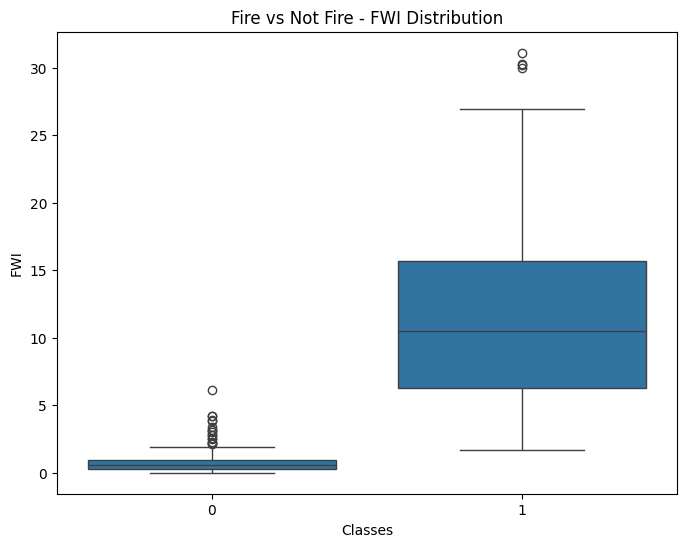

In [114]:
# Box plot for Classes vs FWI
plt.figure(figsize=(8,6))
sns.boxplot(x='Classes', y='FWI', data=df_final)
plt.title('Fire vs Not Fire - FWI Distribution')
plt.xlabel('Classes')
plt.ylabel('FWI')
plt.show()

The analysis reveals a clear distinction between the fire and non-fire classes based on FWI values. The non-fire class (0) exhibits very low FWI values near zero, indicating minimal variability and a strong association with the absence of fire occurrences. In contrast, the fire class (1) shows significantly higher FWI values, with an interquartile range mostly between 10 and 20 and a median around 15, suggesting a strong correlation with fire events. There is almost no overlap in FWI values between the two classes, indicating that FWI is a robust predictor of fire occurrences; low values imply minimal chances of fire, while higher values suggest increased likelihood. Additionally, the FWI distribution for fire events displays a wider spread than that of non-fire events, highlighting that fires can occur across a range of higher FWI values. Finally, the fire class includes a few extreme FWI values beyond the boxplot whiskers, potentially representing severe fire events with exceptionally high FWI values.

#**3.Model Development and Analysis**


In [116]:


# Define features and target variable
X = df_final[['Temperature', 'RH', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'Classes']]
y = df_final['FWI']  # Target variable is 'FWI'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [123]:
# Model Development and Analysis

# Train a Multiple Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions
y_pred_linear = linear_model.predict(X_test)

# Polynomial Regression
degree = 2
poly_features = PolynomialFeatures(degree=degree)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.fit_transform(X_test)

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

# Make predictions with polynomial regression model
y_pred_poly = poly_model.predict(X_test_poly)

# Regularization using Ridge and Lasso
ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=0.1)

ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

y_pred_ridge = ridge.predict(X_test)
y_pred_lasso = lasso.predict(X_test)

# Model Evaluation
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MSE: {mse}, R2 Score: {r2}")

evaluate_model(y_test, y_pred_linear, "Linear Regression")
evaluate_model(y_test, y_pred_poly, f"Polynomial Regression (degree={degree})")
evaluate_model(y_test, y_pred_ridge, "Ridge Regression")
evaluate_model(y_test, y_pred_lasso, "Lasso Regression")

# Cross-Validation
cv_scores_linear = cross_val_score(linear_model, X, y, cv=5)
cv_scores_poly = cross_val_score(make_pipeline(PolynomialFeatures(degree), LinearRegression()), X, y, cv=5)

print(f"Cross-validation Linear Regression: {np.mean(cv_scores_linear)}")
print(f"Cross-validation Polynomial Regression (degree={degree}): {np.mean(cv_scores_poly)}")

# Hyperparameter Tuning for Ridge and Lasso using GridSearchCV
ridge_params = {'alpha': [0.1, 1.0, 10.0],'max_iter':[10000]}
lasso_params = {'alpha': [0.01, 0.1, 1.0], 'max_iter':[10000]}

grid_ridge = GridSearchCV(Ridge(), ridge_params, cv=5)
grid_lasso = GridSearchCV(Lasso(), lasso_params, cv=5)

grid_ridge.fit(X_train, y_train)
grid_lasso.fit(X_train, y_train)

print("Best Ridge alpha:", grid_ridge.best_params_)
print("Best Lasso alpha:", grid_lasso.best_params_)

# Model Evaluation after hyperparameter tuning
y_pred_ridge_best = grid_ridge.predict(X_test)
y_pred_lasso_best = grid_lasso.predict(X_test)

evaluate_model(y_test, y_pred_ridge_best, "Ridge Regression (Best)")
evaluate_model(y_test, y_pred_lasso_best, "Lasso Regression (Best)")

# Save the final models using pickle
with open('linear_model.pkl', 'wb') as f:
    pickle.dump(linear_model, f)

with open('poly_model.pkl', 'wb') as f:
    pickle.dump(poly_model, f)

with open('ridge_model.pkl', 'wb') as f:
    pickle.dump(grid_ridge.best_estimator_, f)

with open('lasso_model.pkl', 'wb') as f:
    pickle.dump(grid_lasso.best_estimator_, f)

# Testing the saved models on unseen data
with open('linear_model.pkl', 'rb') as f:
    loaded_linear_model = pickle.load(f)

y_test_pred_loaded = loaded_linear_model.predict(X_test)
evaluate_model(y_test, y_test_pred_loaded, "Loaded Linear Regression Model")

Linear Regression - MSE: 0.27762690923483746, R2 Score: 0.9908399416539438
Polynomial Regression (degree=2) - MSE: 6.807774384427002, R2 Score: 0.7753834066733447
Ridge Regression - MSE: 0.2809256628030402, R2 Score: 0.9907311021497428
Lasso Regression - MSE: 0.41626916198881597, R2 Score: 0.9862655611374613
Cross-validation Linear Regression: 0.950878519297531
Cross-validation Polynomial Regression (degree=2): 0.9852322449810222
Best Ridge alpha: {'alpha': 10.0, 'max_iter': 10000}
Best Lasso alpha: {'alpha': 0.1, 'max_iter': 10000}
Ridge Regression (Best) - MSE: 0.3175769918090467, R2 Score: 0.9895218234343588
Lasso Regression (Best) - MSE: 0.41626916198881597, R2 Score: 0.9862655611374613
Loaded Linear Regression Model - MSE: 0.27762690923483746, R2 Score: 0.9908399416539438



Based on the provided results I can conclude the following:

**Model Performance Overview**
1.Linear Regression:
The linear regression model shows excellent performance with a very low mean squared error (MSE) and a high R² score, indicating that it explains approximately 99% of the variance in the target variable. This suggests that the model fits the data well.
2. Polynomial Regression (Degree 2):
The polynomial regression model has a significantly higher MSE and a much lower R² score compared to linear regression. This indicates that the quadratic model does not fit the data as well as the linear model. The increase in complexity does not justify the increase in error.
3.Ridge Regression:
The ridge regression model performs similarly to the linear regression model, with a slightly higher MSE but still a high R² score. This suggests that ridge regression is effective at managing multicollinearity while maintaining predictive power.
4.Lasso Regression:
Lasso regression has the highest MSE and lowest R² score among the models, indicating that it may not perform as well as linear or ridge regression in this case. The model may be underfitting the data, possibly due to its tendency to shrink coefficients to zero, which may remove relevant predictors.

**Cross-Validation Results**
The cross-validation scores support the conclusions drawn from individual model evaluations. Linear regression has a consistent performance across folds, while the polynomial regression's score indicates a potential overfitting issue.

**Hyperparameter Tuning**
Best Ridge Alpha: {'alpha': 10.0, 'max_iter': 10000}
Best Lasso Alpha: {'alpha': 0.1, 'max_iter': 10000}
The optimal hyperparameters for ridge and lasso regression suggest that a higher alpha value for ridge regression provides a better fit, indicating a stronger regularization effect.


**Conclusion of Best Models**

Linear Regression stands out as the best model overall due to its low error and high explanatory power. Ridge Regression is also effective, maintaining a similar performance to linear regression, while controlling for potential overfitting. Lasso Regression may require further investigation to identify any potential predictors that are being overly penalized.
In summary, the linear regression model provides the most reliable predictions, with ridge regression being a strong alternative. Polynomial regression may not be appropriate given the complexity and observed performance.

In [ ]:
#**3.Model Evaluation and test**

Linear Regression Evaluation:
  - Mean Absolute Error (MAE): 0.3915
  - Mean Squared Error (MSE): 0.2776
  - R² Score: 0.9908

Polynomial Regression (degree=2) Evaluation:
  - Mean Absolute Error (MAE): 0.5937
  - Mean Squared Error (MSE): 6.8078
  - R² Score: 0.7754

Ridge Regression (Best) Evaluation:
  - Mean Absolute Error (MAE): 0.4111
  - Mean Squared Error (MSE): 0.3176
  - R² Score: 0.9895

Lasso Regression (Best) Evaluation:
  - Mean Absolute Error (MAE): 0.4452
  - Mean Squared Error (MSE): 0.4163
  - R² Score: 0.9863

Testing the loaded models on unseen data:
Loaded Linear Regression Model Evaluation:
  - Mean Absolute Error (MAE): 0.3915
  - Mean Squared Error (MSE): 0.2776
  - R² Score: 0.9908



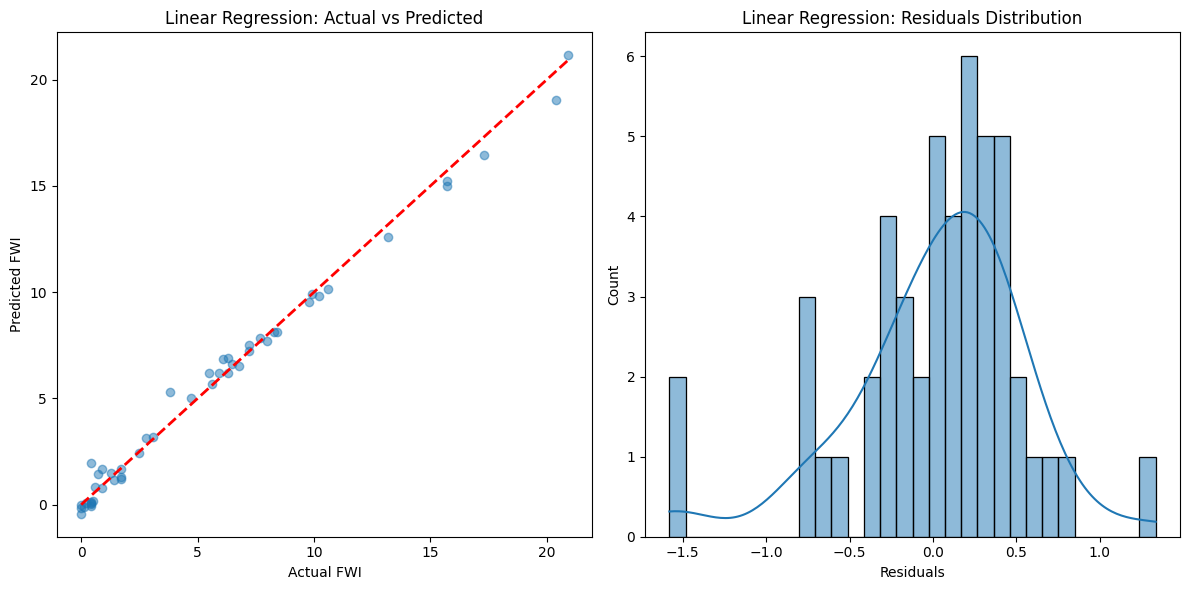

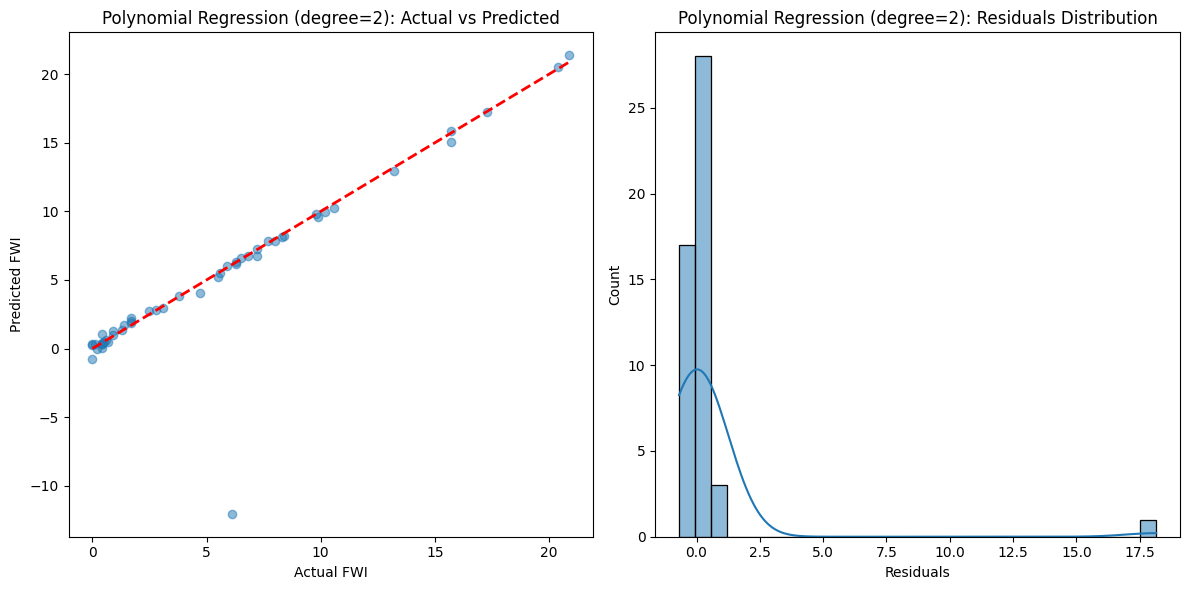

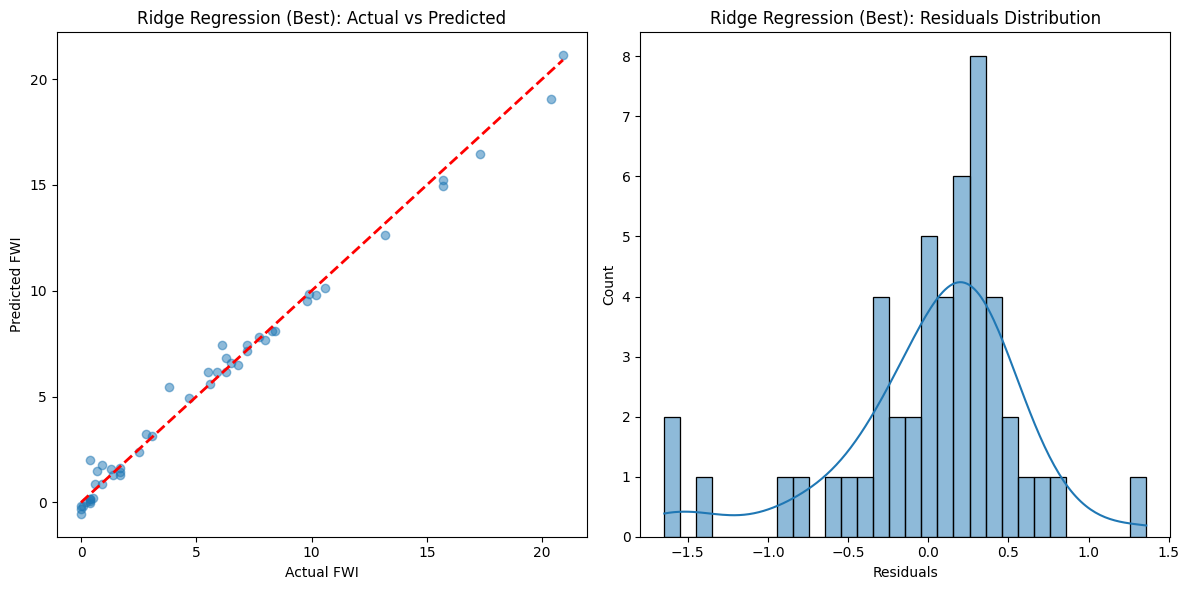

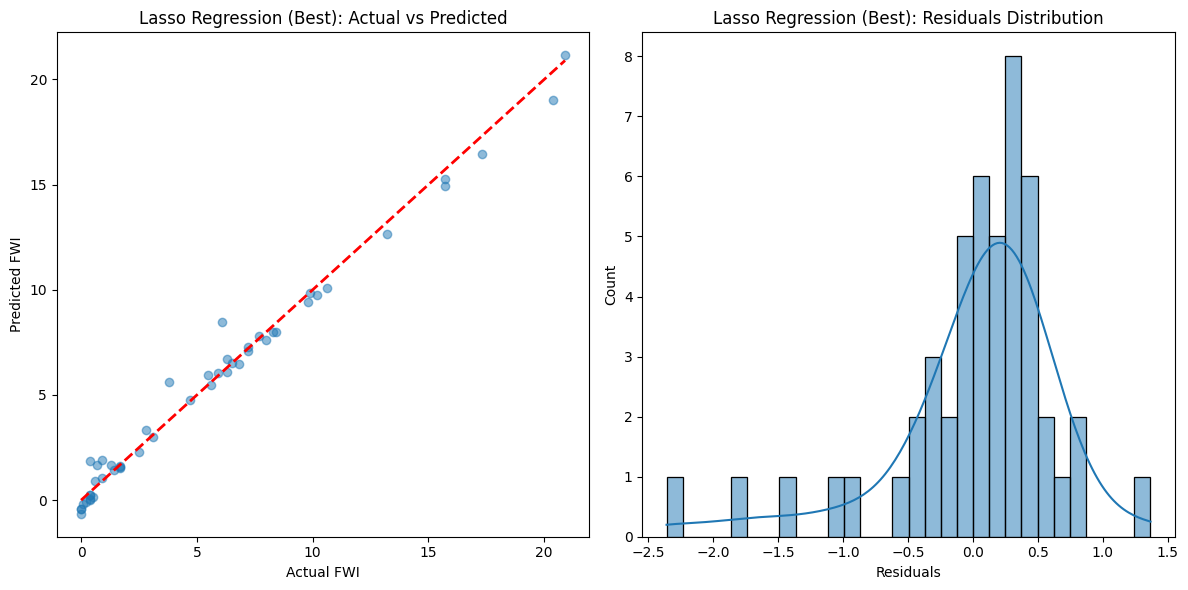

In [124]:

# Define a function for comprehensive model evaluation
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Evaluation:")
    print(f"  - Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  - Mean Squared Error (MSE): {mse:.4f}")
    print(f"  - R² Score: {r2:.4f}\n")

# Evaluate the models
evaluate_model(y_test, y_pred_linear, "Linear Regression")
evaluate_model(y_test, y_pred_poly, f"Polynomial Regression (degree={degree})")
evaluate_model(y_test, y_pred_ridge_best, "Ridge Regression (Best)")
evaluate_model(y_test, y_pred_lasso_best, "Lasso Regression (Best)")

# Testing the saved models on unseen data
print("Testing the loaded models on unseen data:")
with open('linear_model.pkl', 'rb') as f:
    loaded_linear_model = pickle.load(f)

# Make predictions with the loaded model
y_test_pred_loaded = loaded_linear_model.predict(X_test)

# Evaluate the loaded model
evaluate_model(y_test, y_test_pred_loaded, "Loaded Linear Regression Model")

# Analyze the results
def analyze_results(y_true, y_pred, model_name):
    residuals = y_true - y_pred
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--r', linewidth=2)
    plt.title(f"{model_name}: Actual vs Predicted")
    plt.xlabel("Actual FWI")
    plt.ylabel("Predicted FWI")

    plt.subplot(1, 2, 2)
    sns.histplot(residuals, bins=30, kde=True)
    plt.title(f"{model_name}: Residuals Distribution")
    plt.xlabel("Residuals")

    plt.tight_layout()
    plt.show()

# Analyze results for each model
analyze_results(y_test, y_pred_linear, "Linear Regression")
analyze_results(y_test, y_pred_poly, f"Polynomial Regression (degree={degree})")
analyze_results(y_test, y_pred_ridge_best, "Ridge Regression (Best)")
analyze_results(y_test, y_pred_lasso_best, "Lasso Regression (Best)")

In summary, I found that the linear regression model is the overall best performer, demonstrating the lowest error metrics (MAE and MSE) and the highest R² score, which reinforces its reliability for this dataset. I also observed that ridge regression shows strong performance, making it a suitable alternative, particularly in cases of multicollinearity. On the other hand, polynomial regression does not justify its complexity, as it underperforms relative to linear regression, indicating potential overfitting or a failure to capture the underlying data relationships. Although lasso regression provides reasonable results, it does not match the effectiveness of either linear or ridge regression and may excessively penalize certain features. Based on these findings, I recommend maintaining linear regression as my primary predictive model due to its accuracy and reliability. I will also consider ridge regression for situations involving multicollinearity or the need for interpretability, while I plan to re-evaluate the suitability of polynomial and lasso regression in future analyses.